In [59]:
import json
from types import *
from dataloader import *
from util import *
from graphs import *
from agreement import *

data = []

# Load David's preliminary data
# with open('../preliminary/david-first-eighty.json') as f:
#     data += json.load(f)

# Load tutorial feedback
# for filename in os.listdir('../tutorial/'):
#     with open('../tutorial/' + filename) as f:
#         individual_annotation = json.load(f)
#         for entry in individual_annotation:
#             entry['user'] = filename.split('.')[0]
#         data += individual_annotation

# Load batch 1 data
batch_num = 1
files = [x for x in os.listdir('../annotated/') if x.startswith('batch_' + str(batch_num))]
files = [x for x in files if 'rachel' not in x]
# files = [
#     'batch_1_anton.json',
#     'batch_1_ayush.json',
#     'batch_1_kelly.json'
# ]
for filename in files:
    with open('../annotated/' + filename) as f:
        individual_annotation = json.load(f)
        
        for entry in individual_annotation:
            entry['user'] = filename.split('.')[0].split('_')[-1]
        data += individual_annotation

data = consolidate_edits(data)          # Adds 'edits' field
data = consolidate_annotations(data)    # Adds 'processed_annotations' field

Couldn't process grammar for annotation: ['positive', '', '', '']
Couldn't process grammar for annotation: ['positive', 'minor', '', '']
Couldn't process grammar for annotation: ['positive', 'a lot', '', '']
Couldn't process grammar for annotation: ['positive', 'somewhat', '', '']


In [60]:
# Print spans with comments
get_comments(data)

ANTON - HIT 19: in this case later baptised is a perfect deletion, but in other cases it might not be. 

AYUSH - HIT 10: There is no change from the original sentence to simplified sentence
AYUSH - HIT 15: Seems to think the original sentence is talking about a game?
AYUSH - HIT 25: It's the same sentence just duplicated twice
KELLY - HIT 6: This original sentence doesn't really make geographic sense. Tajikistan, Turmenistan, and Uzbekistan are north of both Afghanistan and Pakistan, east of Iran, and west of China.
KELLY - HIT 10: No change?
KELLY - HIT 15: This hit keeps breaking the interface for me, so I'm not sure what the data looks like. Once I get to this hit, the interface will not allow me to navegate off.
KELLY - HIT 16: I researched it and it looks like the (e) is indicating an alternate spelling on her name, but I'm not sure.
KELLY - HIT 25: Same sentence, no annotations needed.

KELLY - HIT 40: Annotating the splits is causing the interface to glitch and annotations stop 

In [61]:
# The systems we looked at
systems = set([x['system'] for x in data])

# Edit types
edit_types = set(data[0]['annotations'].keys())

In [62]:
# Example: Searches for coreference errors
deletions = [process_annotation(k) for k in [i for j in [[x for x in sent['edits'] if x['type'] == 'deletion'] for sent in data] for i in j]]
for d in deletions:
    if d['error_type'] == Error.COREFERENCE:
        print(d)

{'edit_type': 'deletion', 'id': 1, 'information_impact': <Information.LESS: 'Less Information'>, 'type': <Quality.ERROR: 'Error'>, 'grammar_error': False, 'error_type': <Error.COREFERENCE: 'Coreference'>, 'rating': 1, 'size': 4}
{'edit_type': 'deletion', 'id': 0, 'information_impact': <Information.LESS: 'Less Information'>, 'type': <Quality.ERROR: 'Error'>, 'grammar_error': False, 'error_type': <Error.COREFERENCE: 'Coreference'>, 'rating': 0, 'size': 2}


In [63]:
# Example: Annotations for sentence 0
data[0]['processed_annotations']

[{'edit_type': 'deletion',
  'id': 0,
  'information_impact': <Information.LESS: 'Less Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': True,
  'error_type': None,
  'rating': 2,
  'size': 0.09278350515463918}]

In [64]:
# Example: Edits for sentence 0
data[0]['edits']

[{'type': 'deletion',
  'id': 0,
  'original_span': (11, 20),
  'simplified_span': None,
  'annotation': ['good', 'yes', 'no']}]

In [65]:
# Example: Agreement between annotators on edit types
# for edit_type in ['deletion', 'insertion', 'reorder', 'substitution']:
#     print(f'{edit_type} -> {calculate_agreement(data, edit_type, drop_no_spans=True)}')

In [66]:
# TODO: trivial edits on substitutions aren't being processed correctly
# for sent in data:
#     for ann in sent['processed_annotations']:
#         if ann['type'] == Quality.TRIVIAL and ann['rating'] == None:
#             print(sent['id'])
#             print(ann)
#             print(sent['system'])
#             print(sent['system'])
#             print(sent['user'])

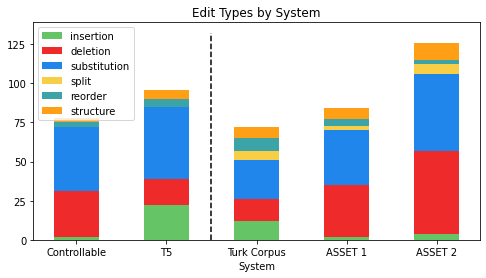

In [67]:
edit_type_by_system(data, flipped=True)

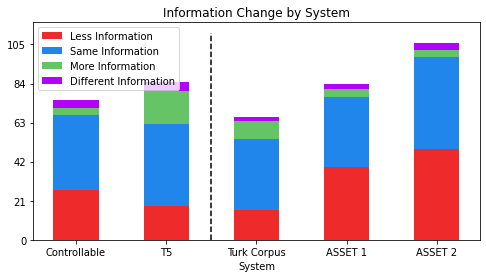

In [68]:
system_by_information_change(data)

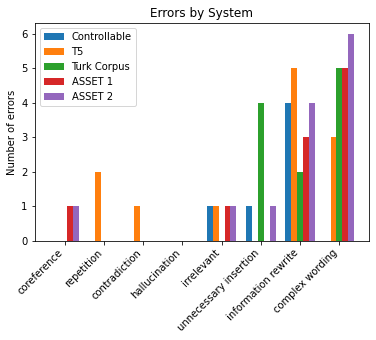

In [69]:
errors_by_system(data)

In [70]:
sankey_seperated(data)

In [71]:
sankey_combined(data)

In [81]:
for error in [Error.REPETITION, Error.CONTRADICTION, Error.HALLUCINATION, Error.IRRELEVANT]:
    print(error.value)
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['error_type'] == error:
                print(f'HIT {sent["id"]+1} \t {sent["user"]} \t {system_name_mapping[sent["system"]]}')
    print()

Repetition
HIT 23 	 anton 	 T5
HIT 23 	 ayush 	 T5

Contradiction
HIT 8 	 kelly 	 T5

Hallucination

Irrelevant
HIT 29 	 anton 	 Controllable
HIT 31 	 anton 	 ASSET 2
HIT 23 	 kelly 	 T5
HIT 50 	 kelly 	 ASSET 1

